In [50]:
from sys import path as syspath
from pathlib import Path

syspath.append(str(Path().home() / "pyref" / "src"))

import pyref as rf
import seaborn as sns
import matplotlib.pyplot as plt
import pickle as pkl
import pandas as pd
import numpy as np
from pypxr.structure import *
from pypxr.reflectivity import *
from refnx.dataset import ReflectDataset
from refnx.analysis import Transform, CurveFitter, Objective, GlobalObjective
from refnx._lib.emcee.moves.de import DEMove
from typing import Literal

import scienceplots
plt.style.use(["science", "no-latex"])

db = rf.db()

znpc_oc = db.get_oc("C32H16N8Zn")

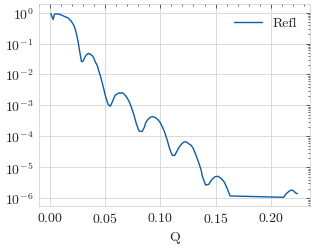

In [51]:
s = db.get_refl("zrt_250.0_100.csv", "ZnPc")
p = db.get_refl("zrt_250.0_190.csv", "ZnPc")

en = 250
# mask where p pol dataframe is less than 1e-6
p.drop(p[p["Refl"] < 1e-6].index, inplace=True)
p.plot(x="Q", y="Refl", logy=True)

data = rf.to_refnx_dataset(s, pol="sp", second_pol=p)

In [52]:
znpc_mono_struct_file = db.get_struct("ZnPc_RoomTemp")
znpc_oc = db.get_oc("C32H16N8Zn")

si_thick = znpc_mono_struct_file["Si"]["thickness"]
si_rough = znpc_mono_struct_file["Si"]["roughness"]
si_density = znpc_mono_struct_file["Si"]["density"]

sio2_thick = znpc_mono_struct_file["SiO2"]["thickness"]
sio2_rough = znpc_mono_struct_file["SiO2"]["roughness"]
sio2_density = znpc_mono_struct_file["SiO2"]["density"]

c_amor_thick = znpc_mono_struct_file["C"]["thickness"]
c_amor_rough = znpc_mono_struct_file["C"]["roughness"]
c_amor_density = znpc_mono_struct_file["C"]["density"]

znpc_thick = znpc_mono_struct_file["C32H16N8Zn"]["thickness"]
znpc_rough = znpc_mono_struct_file["C32H16N8Zn"]["roughness"]
znpc_density = znpc_mono_struct_file["C32H16N8Zn"]["density"]

In [53]:
vac = PXR_MaterialSLD("", 0, en)(0, 0)

surf_thick = 9.53276
surf_rough = 7.52292

patern_thick = 9.51586
patern_rough = 3.72188

bulk = PXR_MaterialSLD("C32H16N8Zn1", znpc_density, en, name="ZnPc")(
    znpc_thick, znpc_rough
)

surf_thick = 9.53276
surf_rough = 7.52292

c_amor = PXR_MaterialSLD("C", c_amor_density, en, name="C")(c_amor_thick, c_amor_rough)

si = PXR_MaterialSLD("Si", 2.33, en, name="Si")(si_thick, si_rough)
sio2 = PXR_MaterialSLD("SiO2", sio2_density, en, name="SiO2")(sio2_thick, sio2_rough)

<Axes: xlabel='z / $\\AA$', ylabel='Index of refraction'>

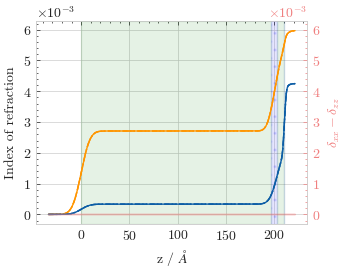

In [55]:
from numpy import array
struc = vac | bulk | c_amor | sio2 | si

si.thick.setp(vary=False)
si.rough.setp(vary=False)

sio2.thick.setp(vary=True, bounds=(0, sio2_thick*1.2))
sio2.rough.setp(vary=True, bounds=(0, sio2_rough*1.2))
sio2.sld.density.setp(vary=True, bounds=(sio2_density*0.8, sio2_density*1.2))

c_amor.thick.setp(vary=True, bounds=(0, surf_thick*1.2))
c_amor.rough.setp(vary=True, bounds=(0, surf_rough*1.2))
c_amor.sld.density.setp(vary=True, bounds=c_amor.sld.density.value * array([0.8, 1.2]))

bulk.thick.setp(vary=True, bounds=(0, surf_thick*1.2))
bulk.rough.setp(vary=True, bounds=(0, surf_rough*1.2))
bulk.sld.density.setp(vary=True, bounds=c_amor.sld.density.value * array([0.8, 1.2]))

struc.plot()

________________________________________________________________________________
Objective - 250eV
Dataset = <None>, 223 points
datapoints = 223
chi2 = 2663.173825678677
Weighted = True
Transform = Transform('logY')
________________________________________________________________________________
Parameters:      '250'     
________________________________________________________________________________
Parameters: 'instrument parameters'
<Parameter:'dq - resolution', value=0  (fixed) , bounds=[-inf, inf]>
<Parameter:  'q_offset'   , value=0  (fixed) , bounds=[-inf, inf]>
<Parameter:  'en_offset'  , value=0  (fixed) , bounds=[-inf, inf]>
<Parameter:     'bkg'     , value=0  (fixed) , bounds=[-inf, inf]>
<Parameter:   'scale_s'   , value=1          , bounds=[0.6, 1.2]>
<Parameter:   'scale_p'   , value=1          , bounds=[0.6, 1.2]>
<Parameter:'theta_offset_s', value=0.5          , bounds=[-1.0, 1.0]>
<Parameter:'theta_offset_p', value=-0.5          , bounds=[-1.0, 1.0]>
_______________

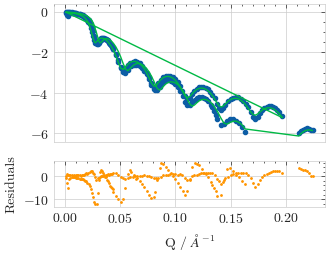

In [56]:
from pyref.fitting.logp import LogpExtra_rough as LogpExtra

model = PXR_ReflectModel(struc, pol = "sp", energy = en, name = f"250", theta_offset={"s": .5, "p": -.5})
model.scale_s.setp(vary = True, bounds = (0.6, 1.2))
model.scale_p.setp(vary = True, bounds = (0.6, 1.2))
model.theta_offset_s.setp(vary = True, bounds = (-1, 1))
model.theta_offset_p.setp(vary = True, bounds = (-1, 1))

obj = Objective(model, data, transform=Transform("logY"), name = f"250eV")
print(obj)
lpe = LogpExtra(obj)
obj.logp_extra = lpe
obj.plot(resid=True)
print(obj.varying_parameters())

In [57]:
import pickle as pkl

class Fitter:
    # Suppresses the warning
    from warnings import simplefilter

    simplefilter("ignore")

    def __init__(self, obj: Objective | GlobalObjective, en, walkers_per_param=10, burn_in = 0):
        self.obj = obj
        self.move = [
            (DEMove(sigma=1e-7), 0.90),
            (DEMove(sigma=1e-7, gamma0=1), 0.1),
        ]
        if obj.__class__.__name__ == "GlobalObjective":
            self.n_params = sum([len(o.data.data[0]) - len(o.varying_parameters()) for o in obj.objectives])
        else:
            self.n_params = len(self.obj.data.data[0]) - len(self.obj.varying_parameters())
        self._n_walkers = walkers_per_param*len(self.obj.varying_parameters())
        self.burn_in = burn_in
        self.fitter = CurveFitter(obj, nwalkers=self._n_walkers, moves=self.move)
        self.en = en

    @property
    def n_walkers(self):
        return self._n_walkers

    @n_walkers.setter
    def n_walkers(self, value):
        self._n_walkers = value
        self.fitter = CurveFitter(self.obj, nwalkers=self._n_walkers, moves=self.move)

    def red_chisqr(self):
        try:
            return self.obj.chisqr() / self.n_params
        except:
            return np.nan

    def fit(
        self,
        steps_per_param=20,
        thin=1,
        seed=1,
        init: Literal["jitter", "prior"] = "jitter",
        show_output=False,
    ):
        steps = steps_per_param * self.n_params
        burn = int(steps * self.burn_in)

        self.fitter.initialise(init, random_state=seed)
        self.chain = self.fitter.sample(
            steps,
            random_state=seed,
            nthin=thin,
            skip_initial_state_check=True,
            nburn=burn,
        )
        print(f"Reduced χ2 = {self.red_chisqr()}")
        if show_output:
            self.show_output()
            self.export(f"{self.en}.pkl")

    def show_output(self):
        print(self.obj.varying_parameters())
        fig, ax = plt.subplots()
        lp = self.fitter.logpost
        ax.plot(-lp)
        if self.obj.__class__.__name__ == "GlobalObjective":
            for o in self.obj.objectives:
                o.plot(resid=True)
                plt.show()
        else:
            self.obj.plot(resid=True)
            plt.show()
        self.export(f"{self.en}.pkl")

    def export(self, filename: str):
        with open(filename, "wb") as f:
            pkl.dump(self, f)

    def delete_obj(self):
        del self

class MultiEnFitter:
    def __init__(self, objs: list[Objective], en_list: list[float]):
        self.objs = objs
        self.ens = en_list

    def fit_obj(self,n: int, N: int = 1, fitter = None, reset = False):
        if fitter is None:
            fitter = Fitter(obj = self.objs[n], en = self.ens[n])
            fitter.fit(init="jitter", steps_per_param=20*N)

        fitter.fit(init="jitter", steps_per_param=5*N)
        if fitter.red_chisqr() > 1 and N < 4:
            print(f"Red χ2 = {fitter.red_chisqr()}. Refitting with {N+1}x walkers")
            N+=2
            self.fit_obj(n, N, fitter, reset)
        else:
            fitter.show_output()
            fitter.export(f"{self.objs[n].model.name}.pkl")

    def fit(self, N: int = 1):
        for i in range(len(self.objs)):
            print(f"Fitting {self.objs[i].name}")
            self.fit_obj(i, N)

In [58]:
fitter = MultiEnFitter([obj], [en])
fitter.fit()

Fitting 250eV


100%|██████████| 4200/4200 [09:33<00:00,  7.32it/s]


Reduced χ2 = 43.33160895331956


100%|██████████| 1050/1050 [02:19<00:00,  7.51it/s]


Reduced χ2 = 43.250305448629696
Red χ2 = 43.250305448629696. Refitting with 2x walkers


100%|██████████| 3150/3150 [06:21<00:00,  8.26it/s]


Reduced χ2 = 43.24018847605013
Red χ2 = 43.24018847605013. Refitting with 4x walkers


 74%|███████▍  | 3882/5250 [07:38<02:41,  8.47it/s]


KeyboardInterrupt: 